In [1]:
import pandas as pd
from glicko2 import Player

# Load the Excel file
file_path = '/users/marclambertes/Downloads/Database Men 2023-2024/Segunda Liga - 2023-2024.xlsx'
df = pd.read_excel(file_path)
df = df[(df['Minutes played'] >= 180) & (df['Position'] != 'GK')]

# Define a custom class for Aerial Duel Players
class AerialDuelPlayer(Player):
    def __init__(self, name, height, position, aerial_duels_per_90, aerial_win_pct, team, rating=1500, rd=350, vol=0.06):
        super().__init__(rating, rd, vol)
        self.name = name
        self.height = height
        self.position = position
        self.aerial_duels_per_90 = aerial_duels_per_90
        self.aerial_win_pct = aerial_win_pct
        self.team = team

    def calculate_weighted_score(self):
        """Calculate a weighted score based on aerial duels per 90, height, and aerial win percentage."""
        return (
            0.5 * self.aerial_duels_per_90 +
            1.0 * self.height +
            1.5 * self.aerial_win_pct
        )

    def match_outcome(self, opponent):
        """Calculate the match outcome based on the weighted score."""
        win_margin = self.calculate_weighted_score() - opponent.calculate_weighted_score()
        if win_margin > 5:
            return 1  # Win
        elif win_margin < -5:
            return 0  # Loss
        else:
            return 0.5  # Draw

    def constrained_update_player(self, opponent_ratings, opponent_rds, outcomes):
        """Update the player rating while applying constraints to prevent overflow errors."""
        # Constrain RD and ensure it stays within a safe range
        self.rd = min(max(self.rd, 30), 350)
        opponent_rds = [min(max(rd, 30), 350) for rd in opponent_rds]

        # Constrain the player's rating (rating) to avoid extreme values
        self.rating = min(max(self.rating, 1000), 2000)

        # Constrain volatility to prevent instability
        self.vol = min(max(self.vol, 0.01), 1.2)

        try:
            # Attempt to update using the original Glicko2 update method
            self.update_player(opponent_ratings, opponent_rds, outcomes)
        except OverflowError:
            print(f"Overflow error encountered for player {self.name}. Skipping update for this match.")
        except ValueError:
            print(f"ValueError encountered for player {self.name}. Skipping update for this match.")

# Create Player Objects from the Excel Data
players = []
for _, row in df.iterrows():
    player = AerialDuelPlayer(
        name=row['Player'],
        height=row['Height'],
        position=row['Position'],
        aerial_duels_per_90=row['Aerial duels per 90'],
        aerial_win_pct=row['Aerial duels won, %'],
        team=row['Team']  # Include the team
    )
    players.append(player)

# Simulate matches (e.g., round-robin format)
for player in players:
    opponents = [op for op in players if op != player]
    outcomes = [player.match_outcome(op) for op in opponents]
    
    # Extract numeric ratings and rating deviations for the opponents
    opponent_ratings = [op.rating for op in opponents]
    opponent_rds = [op.rd for op in opponents]
    
    # The weight list can be calculated based on aerial duels per 90 (as a proxy for activity level)
    weights = [op.aerial_duels_per_90 for op in opponents]
    
    # Normalize the weights (optional, based on your model preference)
    if sum(weights) > 0:
        weights = [w / sum(weights) for w in weights]
    else:
        weights = [1] * len(weights)  # In case of zero values, default to equal weighting

    # Update the player rating using the constrained method to avoid overflow
    player.constrained_update_player(opponent_ratings, opponent_rds, outcomes)

# Calculate the final weighted rating based on the player's attributes and the Glicko rating
updated_data = []
for player in players:
    weighted_rating = (
        0.5 * player.aerial_duels_per_90 +
        1.0 * player.height +
        1.5 * player.aerial_win_pct +
        player.rating  # Add the Glicko rating as part of the final score
    )
    updated_data.append({
        "Player": player.name,
        "Height": player.height,
        "Position": player.position,
        "Team": player.team,  # Include the team in the output
        "Glicko Rating": player.rating,
        "Deviation": player.rd,
        "Volatility": player.vol,
        "Weighted Rating": weighted_rating
    })

# Convert the updated data into a DataFrame for easier handling
updated_df = pd.DataFrame(updated_data)

# Normalize the weighted ratings to a 0-100 scale
min_rating = updated_df['Weighted Rating'].min()
max_rating = updated_df['Weighted Rating'].max()
updated_df['Score (0-100)'] = ((updated_df['Weighted Rating'] - min_rating) / (max_rating - min_rating)) * 100

print(updated_df)

# Save the updated ratings back to an Excel file with the additional "Team within selected timeframe" column
updated_df.to_excel('IHR Croatia 2324.xlsx', index=False)


               Player  Height      Position             Team  Glicko Rating  \
0         João Miguel     190       LCB, CB         Penafiel    1825.839618   
1         Léo Bolgado     190       CB, LCB          Leixões    1976.060443   
2             Clayton     187           LCB             AVS     1858.377121   
3         João Afonso     188       CB, LCB        Torreense    1908.328546   
4             O. Diao     187  RB, LCB, RCB            Mafra    1843.051549   
..                ...     ...           ...              ...            ...   
397       Jota Garcês     176     LCMF, AMF         Nacional    1596.749580   
398        Madi Queta     180    LAMF, RAMF           Sabail    1663.006062   
399  Zainadine Júnior     178           RCB         Marítimo    1684.072285   
400       Tomás Silva     182     DMF, RCMF  Academico Viseu    1300.212309   
401  Ricardo Teixeira     188      LCB, RCB          Leixões    2094.573754   

     Deviation  Volatility  Weighted Rating  Score 

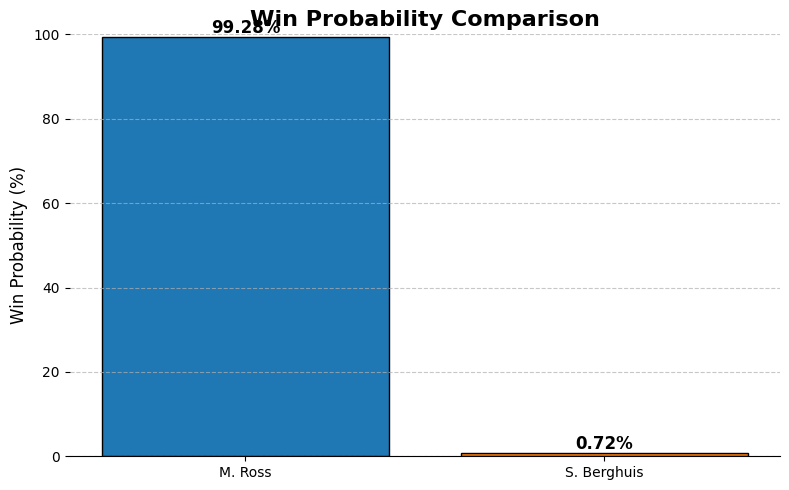

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the updated ratings from the Excel file
file_path = 'updated_player_ratings.xlsx'
df_ratings = pd.read_excel(file_path)

# Function to calculate win probability between two ratings
def calculate_win_probability(rating_a, rating_b):
    """Calculate the win probability of player A against player B."""
    return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))

# Select two players by name
player_a_name = 'M. Ross'  # Replace with actual player name from the Excel file
player_b_name = 'S. Berghuis'  # Replace with actual player name from the Excel file

# Retrieve ratings for the selected players
player_a = df_ratings[df_ratings['Player'] == player_a_name]
player_b = df_ratings[df_ratings['Player'] == player_b_name]

if not player_a.empty and not player_b.empty:
    rating_a = player_a.iloc[0]['Weighted Rating']
    rating_b = player_b.iloc[0]['Weighted Rating']
    
    # Calculate win probabilities
    win_prob_a_vs_b = calculate_win_probability(rating_a, rating_b) * 100
    win_prob_b_vs_a = calculate_win_probability(rating_b, rating_a) * 100
    
    # Create a bar chart for visualizing win probabilities
    players = [player_a_name, player_b_name]
    probabilities = [win_prob_a_vs_b, win_prob_b_vs_a]

    # Define colors for the bars
    colors = ['#1f77b4', '#ff7f0e']

    # Plotting the bar chart
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.bar(players, probabilities, color=colors, edgecolor='black')

    # Add title and labels
    ax.set_title('Win Probability Comparison', fontsize=16, weight='bold')
    ax.set_ylabel('Win Probability (%)', fontsize=12)
    ax.set_ylim(0, 100)

    # Annotate bars with probability values
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', fontsize=12, weight='bold')

    # Customizing the visual appearance
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Display the plot
    plt.tight_layout()
    plt.show()
else:
    print("One or both players not found in the Excel file.")


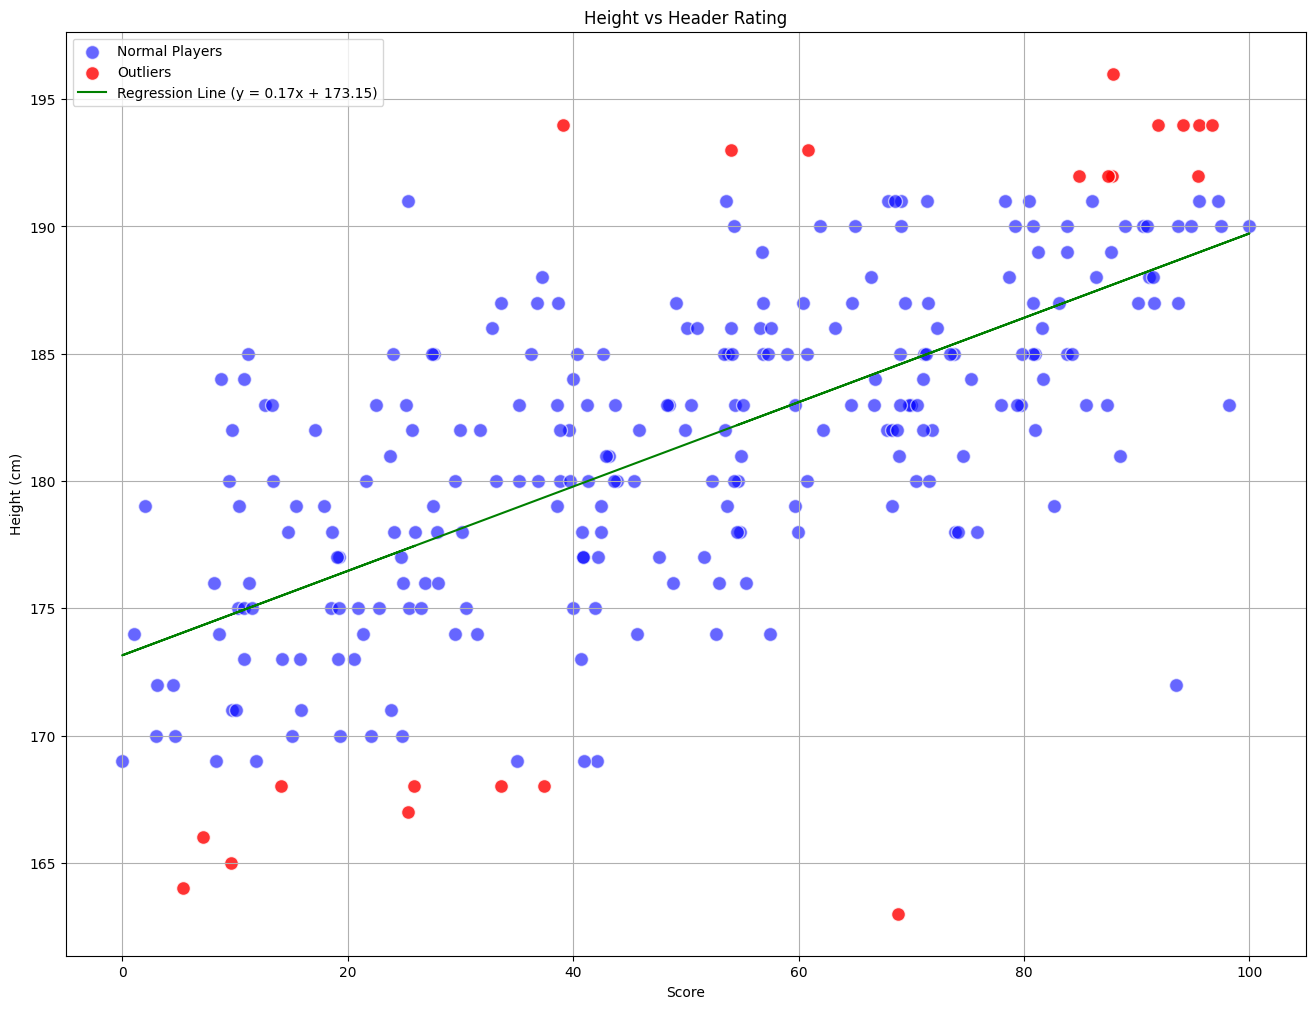

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore

# Scatter plot
plt.figure(figsize=(16, 12))

# Calculate the Z-scores for the heights
updated_df['Height Z-Score'] = zscore(updated_df['Height'])

# Identify outliers
outliers = updated_df[(updated_df['Height Z-Score'] > 1.5) | (updated_df['Height Z-Score'] < -2)]
non_outliers = updated_df[(updated_df['Height Z-Score'] <= 1.5) & (updated_df['Height Z-Score'] >= -2)]

# Plot non-outliers
plt.scatter(non_outliers['Score (0-100)'], non_outliers['Height'], c='blue', alpha=0.6, edgecolors='w', s=100, label='Normal Players')

# Plot outliers in a different color (e.g., red)
plt.scatter(outliers['Score (0-100)'], outliers['Height'], c='red', alpha=0.8, edgecolors='w', s=100, label='Outliers')

# Add the linear regression line (average line)
x = updated_df['Score (0-100)']
y = updated_df['Height']

# Perform linear regression
slope, intercept = np.polyfit(x, y, 1)
regression_line = slope * x + intercept
plt.plot(x, regression_line, color='green', label=f'Regression Line (y = {slope:.2f}x + {intercept:.2f})')

# Plot settings
plt.title('Height vs Header Rating')
plt.xlabel('Score')
plt.ylabel('Height (cm)')
plt.grid(True)

# Display the legend
plt.legend()

# Show the plot
plt.show()


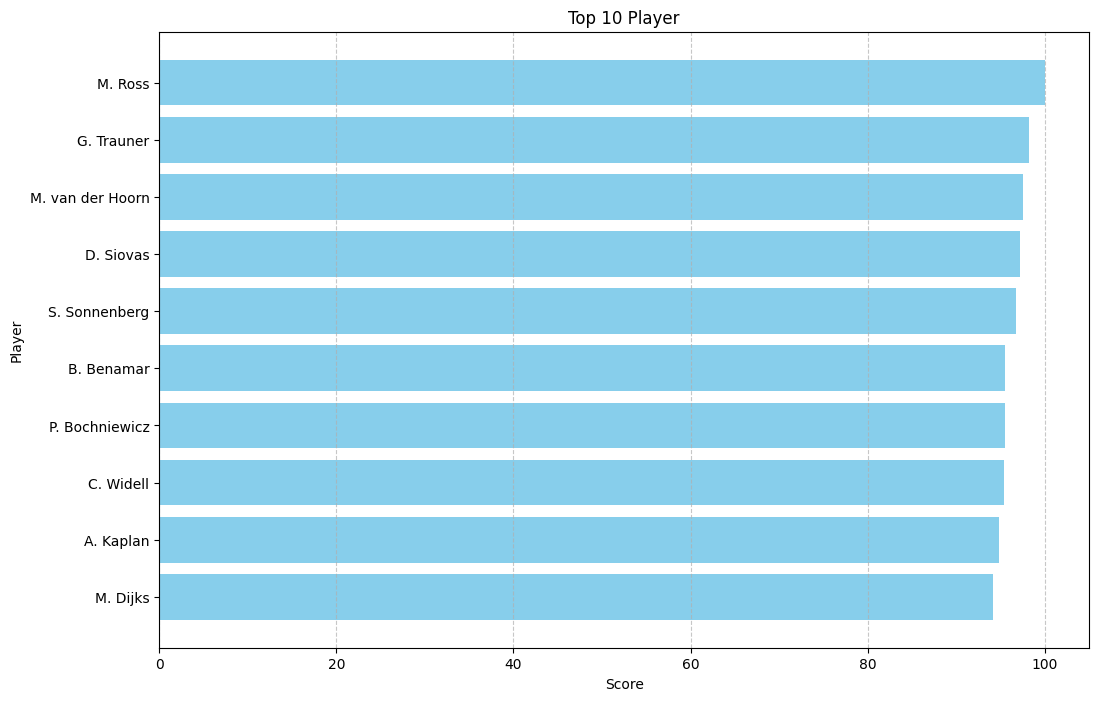

In [43]:
import matplotlib.pyplot as plt

# Sort the DataFrame by the score for better visualization and select the top 10 players
top_10_df = updated_df.sort_values(by='Score (0-100)', ascending=False).head(10)

# Create a horizontal bar graph
plt.figure(figsize=(12, 8))
plt.barh(top_10_df['Player'], top_10_df['Score (0-100)'], color='skyblue')

# Plot settings
plt.title('Top 10 Player')
plt.xlabel('Score')
plt.ylabel('Player')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # Invert the y-axis so the top player appears at the top

# Show the plot
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/marclambertes/Downloads/Images/Sparta Praha.png'

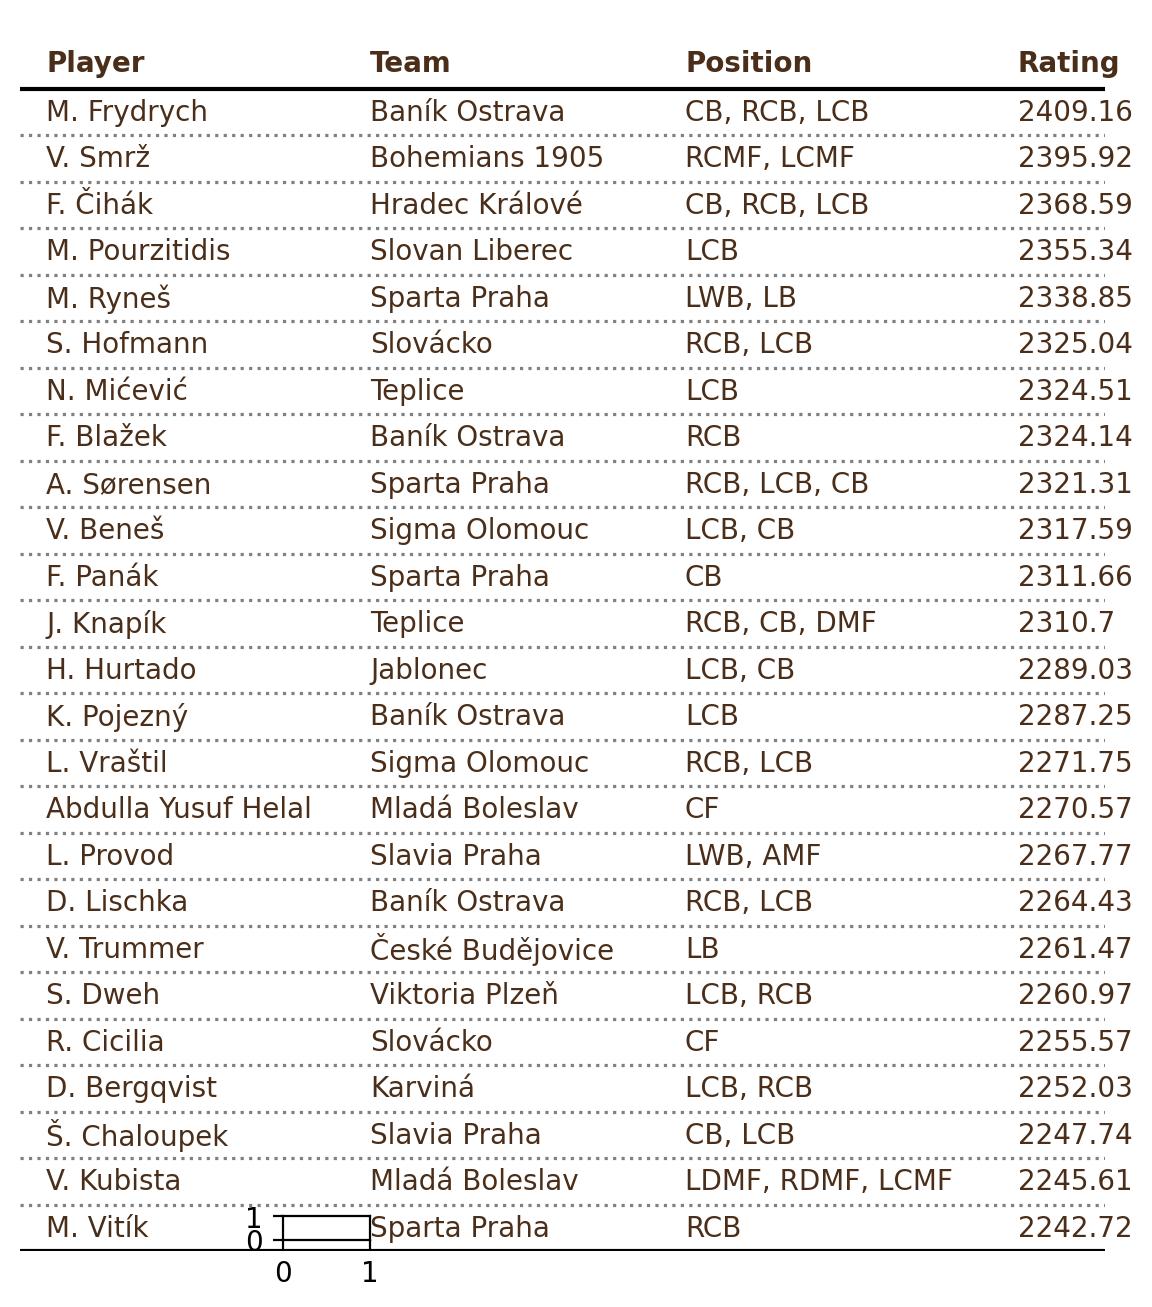

In [2]:
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
from mplsoccer.pitch import VerticalPitch
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter


df = pd.read_excel('/Users/marclambertes/updated_player_ratings_with_team_and_score.xlsx')
df = df.rename(columns={'Team within selected timeframe': 'Team'})
df = df.rename(columns={'Score (0-100)': 'Score'})
df = df[df['Player'] != 'S. van Beek']
df = df[df['Player'] != 'N. Isimat-Mirin']
df = df[df['Player'] != 'M. Sagnan']
#df = df[df['Team'].isin(['Ajax', 'NEC'])]



df['Rating'] = (df['Weighted Rating']).round(2)
df = df.sort_values(by='Rating', ascending=False).head(25)


def ax_logo(team, ax,):
    path = r'/Users/marclambertes/Downloads/Images'
    club_icon = Image.open('%s/%s.png' %(path,team))
    ax.imshow(club_icon)
    ax.axis('off')
    return ax

indexdf = df.head(25)[['Player', 'Team', 'Position', 'Rating']].reset_index(drop=True)
indexdf_short=indexdf[::-1]


fig = plt.figure(figsize=(7,8), dpi=200)
ax = plt.subplot()

ncols = len(indexdf_short.columns.tolist())+1
nrows = indexdf_short.shape[0]

ax.set_xlim(0, ncols + 1.2)
ax.set_ylim(0, nrows + 1.5)

# lgs = ['J1', 'J2', 'Ekstraklasa', 'J3']
# if lg in lgs:
positions = [0.15, 2.0, 3.8, 5.7]
# else:
#     positions = [0.25, 2.25, 3.75, 4.5, 5.25]
columns = indexdf_short.columns.tolist()

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        if 'xG per 90' in column:
            text_label = f'{indexdf_short[column].iloc[i]:,.2f}'
            weight = 'regular'
        else:
            text_label = f'{indexdf_short[column].iloc[i]}'
            weight = 'regular'
        ax.annotate(
            xy=(positions[j], i + .5),
            text = text_label,
            ha='left',
            va='center', color='#4A2E19',
            weight=weight
        )

# Add column names
column_names = columns
for index, c in enumerate(column_names):
        ax.annotate(
            xy=(positions[index], nrows + .25),
            text=column_names[index],
            ha='left',
            va='bottom',
            weight='bold', color='#4A2E19'
        )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

ax.set_axis_off()

DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
# -- Add nation axes
ax_point_1 = DC_to_NFC([2.25, 0.25])
ax_point_2 = DC_to_NFC([2.75, 0.75])
ax_width = abs(ax_point_1[0] - ax_point_2[0])
ax_height = abs(ax_point_1[1] - ax_point_2[1])
for x in range(0, nrows):
    ax_coords = DC_to_NFC([1.5, x + .25])
    flag_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_width, ax_height]
    )
    ax_logo(indexdf_short['Team'].iloc[x], flag_ax,)

fig.text(
    x=0.13, y=.88,
    s='Individual Heading Rating',
    ha='left',
    va='bottom',
    weight='bold',
    size=16, color='#4A2E19'
)
fig.text(
    x=0.15, y=0.10,
    s='Data as of 19/08/2024 | Data: Own metric | Created: Marc Lamberts - @lambertsmarc\nMetric calculated with glicko2 method, using aerial duels and height',
    ha='left',
    va='top',
    weight='regular',
    size=8, color='#4A2E19'
)

fig.text(
    x=0.13, y=0.88,
    s='Which players have the best heading ability according to their aerial duels?',
    ha='left',
    va='top',
    weight='regular',
    size=8, color='#4A2E19'
)

plt.savefig('PDS - eer.png',dpi=750,bbox_inches = 'tight', facecolor='white')
#plt.savefig('Similar Players - Momiki.pdf', dpi=750, bbox_inches='tight', facecolor='white')

In [31]:
import pandas as pd
from math import log, sqrt, pi

# Load the updated ratings from the Excel file
file_path = 'updated_player_ratings_with_team_and_score.xlsx'
df_ratings = pd.read_excel(file_path)

# Glicko Constants
q = log(10) / 400

# Function to calculate win probability between two ratings
def calculate_win_probability(rating_a, rating_b):
    """Calculate the win probability of Player A against Player B."""
    return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))

# Function to calculate the updated ratings based on the Glicko2 system
def update_glicko_ratings(rating_a, rd_a, rating_b, rd_b, outcome_a):
    """Update ratings using the Glicko2 system after a match result."""
    
    # Convert RD (Rating Deviation) to variance
    rd_a_var = rd_a ** 2
    rd_b_var = rd_b ** 2
    
    # Calculate g(RD)
    g_rd_b = 1 / sqrt(1 + (3 * q ** 2 * rd_b_var) / (pi ** 2))
    
    # Calculate the expected score (E)
    expected_score_a = 1 / (1 + 10 ** (-g_rd_b * (rating_a - rating_b) / 400))
    
    # Calculate the rating update
    delta_a = q / ((1 / rd_a_var) + (1 / (g_rd_b ** 2 * rd_b_var))) * (outcome_a - expected_score_a)
    
    # Update ratings
    new_rating_a = rating_a + delta_a
    
    # Return the updated rating for player A
    return new_rating_a

# Select two players by name
player_a_name = 'L. Geertruida'  # Replace with actual player name from the Excel file
player_b_name = 'L. de Jong'  # Replace with actual player name from the Excel file

# Retrieve ratings for the selected players
player_a = df_ratings[df_ratings['Player'] == player_a_name]
player_b = df_ratings[df_ratings['Player'] == player_b_name]

if not player_a.empty and not player_b.empty:
    # Store old ratings
    old_rating_a = player_a.iloc[0]['Weighted Rating']
    old_rating_b = player_b.iloc[0]['Weighted Rating']
    rd_a = player_a.iloc[0]['Deviation']
    rd_b = player_b.iloc[0]['Deviation']
    
    # Calculate win probabilities
    win_prob_a_vs_b = calculate_win_probability(old_rating_a, old_rating_b) * 100
    win_prob_b_vs_a = calculate_win_probability(old_rating_b, old_rating_a) * 100
    
    # Print win probabilities as percentages
    print(f"Win probability of {player_a_name} against {player_b_name}: {win_prob_a_vs_b:.2f}%")
    print(f"Win probability of {player_b_name} against {player_a_name}: {win_prob_b_vs_a:.2f}%")
    
    # Assume the outcome: player_a (L. Geertruida) wins (outcome_a = 1)
    outcome_a = 1  # L. Geertruida wins
    outcome_b = 0  # L. de Jong loses

    # Update ratings after the match for both players
    new_rating_a = update_glicko_ratings(old_rating_a, rd_a, old_rating_b, rd_b, outcome_a)
    new_rating_b = update_glicko_ratings(old_rating_b, rd_b, old_rating_a, rd_a, outcome_b)
    
    # Display old and new ratings for both players
    print(f"\nOld rating for {player_a_name}: {old_rating_a:.2f}")
    print(f"New rating for {player_a_name}: {new_rating_a:.2f}")
    print(f"\nOld rating for {player_b_name}: {old_rating_b:.2f}")
    print(f"New rating for {player_b_name}: {new_rating_b:.2f}")
    
    # Update the DataFrame with the new ratings for both players
    df_ratings.loc[df_ratings['Player'] == player_a_name, 'Weighted Rating'] = new_rating_a
    df_ratings.loc[df_ratings['Player'] == player_b_name, 'Weighted Rating'] = new_rating_b

    # Save the updated ratings back to the Excel file
    df_ratings.to_excel('updated_player_ratings_with_new_ratings.xlsx', index=False)
else:
    print("One or both players not found in the Excel file.")


Win probability of L. Geertruida against L. de Jong: 54.70%
Win probability of L. de Jong against L. Geertruida: 45.30%

Old rating for L. Geertruida: 2210.45
New rating for L. Geertruida: 2211.73

Old rating for L. de Jong: 2177.66
New rating for L. de Jong: 2176.38


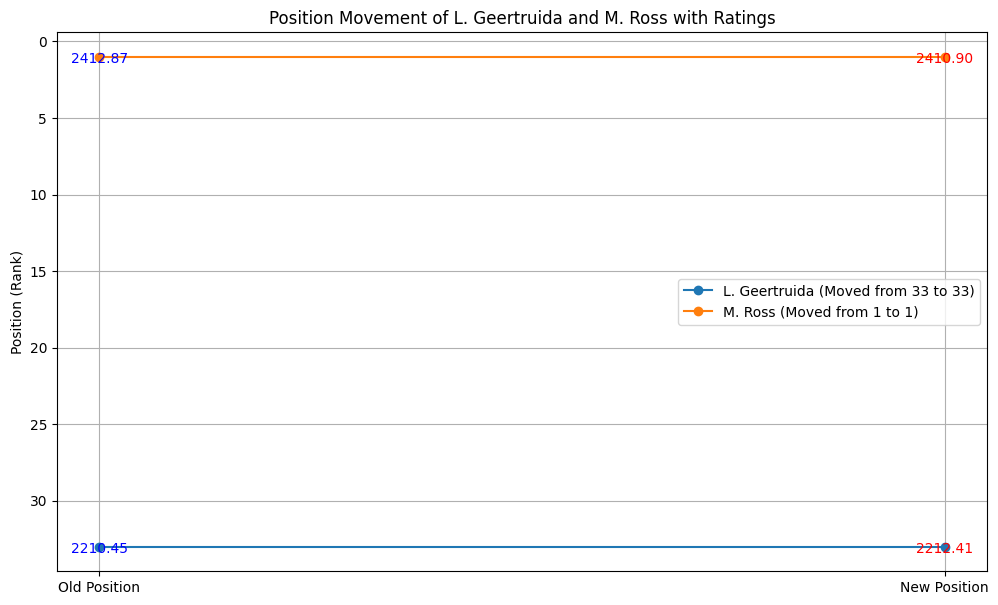

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from math import log, sqrt, pi

# Load the original and updated ratings from the Excel file
file_path = 'updated_player_ratings_with_team_and_score.xlsx'
df_old_ratings = pd.read_excel(file_path)

# Glicko Constants
q = log(10) / 400

# Function to calculate the updated ratings based on the Glicko2 system
def update_glicko_ratings(rating_a, rd_a, rating_b, rd_b, outcome_a):
    rd_a_var = rd_a ** 2
    rd_b_var = rd_b ** 2
    g_rd_b = 1 / sqrt(1 + (3 * q ** 2 * rd_b_var) / (pi ** 2))
    expected_score_a = 1 / (1 + 10 ** (-g_rd_b * (rating_a - rating_b) / 400))
    delta_a = q / ((1 / rd_a_var) + (1 / (g_rd_b ** 2 * rd_b_var))) * (outcome_a - expected_score_a)
    new_rating_a = rating_a + delta_a
    return new_rating_a

# Select two players by name
player_a_name = 'L. Geertruida'
player_b_name = 'M. Ross'

# Retrieve original ratings for the selected players
player_a_old = df_old_ratings[df_old_ratings['Player'] == player_a_name]
player_b_old = df_old_ratings[df_old_ratings['Player'] == player_b_name]

if not player_a_old.empty and not player_b_old.empty:
    old_rating_a = player_a_old.iloc[0]['Weighted Rating']
    old_rating_b = player_b_old.iloc[0]['Weighted Rating']
    rd_a = player_a_old.iloc[0]['Deviation']
    rd_b = player_b_old.iloc[0]['Deviation']
    
    outcome_a = 1  # L. Geertruida wins
    outcome_b = 0  # L. de Jong loses
    
    # Calculate new ratings after the match
    new_rating_a = update_glicko_ratings(old_rating_a, rd_a, old_rating_b, rd_b, outcome_a)
    new_rating_b = update_glicko_ratings(old_rating_b, rd_b, old_rating_a, rd_a, outcome_b)
    
    # Update ratings in the DataFrame
    df_old_ratings.loc[df_old_ratings['Player'] == player_a_name, 'Weighted Rating'] = new_rating_a
    df_old_ratings.loc[df_old_ratings['Player'] == player_b_name, 'Weighted Rating'] = new_rating_b

    # Save the updated ratings
    df_old_ratings.to_excel('updated_player_ratings_with_new_ratings.xlsx', index=False)

# Sort the original and updated ratings to get the top 30 players
df_old_sorted = df_old_ratings.sort_values(by='Weighted Rating', ascending=False).reset_index(drop=True)
df_updated_sorted = df_old_ratings.sort_values(by='Weighted Rating', ascending=False).reset_index(drop=True)

# Extract positions before and after for the selected players
old_position_a = df_old_sorted[df_old_sorted['Player'] == player_a_name].index[0] + 1
old_position_b = df_old_sorted[df_old_sorted['Player'] == player_b_name].index[0] + 1

new_position_a = df_updated_sorted[df_updated_sorted['Player'] == player_a_name].index[0] + 1
new_position_b = df_updated_sorted[df_updated_sorted['Player'] == player_b_name].index[0] + 1

# Create a DataFrame to visualize position changes
movement_df = pd.DataFrame({
    'Player': [player_a_name, player_b_name],
    'Old Position': [old_position_a, old_position_b],
    'New Position': [new_position_a, new_position_b],
    'Old Rating': [old_rating_a, old_rating_b],
    'New Rating': [new_rating_a, new_rating_b]
})

# Plot the movement of the selected players
plt.figure(figsize=(12, 7))
for i, player in enumerate(movement_df['Player']):
    plt.plot(['Old Position', 'New Position'], 
             [movement_df.iloc[i]['Old Position'], movement_df.iloc[i]['New Position']], 
             marker='o', label=f'{player} (Moved from {movement_df.iloc[i]["Old Position"]} to {movement_df.iloc[i]["New Position"]})')

    # Annotate the old and new ratings underneath the dots
    plt.text('Old Position', movement_df.iloc[i]['Old Position'] - 0.3, f'{movement_df.iloc[i]["Old Rating"]:.2f}', 
             horizontalalignment='center', verticalalignment='top', fontsize=10, color='blue')
    plt.text('New Position', movement_df.iloc[i]['New Position'] - 0.3, f'{movement_df.iloc[i]["New Rating"]:.2f}', 
             horizontalalignment='center', verticalalignment='top', fontsize=10, color='red')

# Customize the plot
plt.gca().invert_yaxis()  # Invert y-axis to have rank 1 at the top
plt.xticks(['Old Position', 'New Position'])
plt.ylabel('Position (Rank)')
plt.title('Position Movement of L. Geertruida and M. Ross with Ratings')
plt.legend(loc='best')
plt.grid(True)

# Display the plot
plt.show()
